In [1]:
import pandas
import os
import pixiedust

Pixiedust database opened successfully


### Add your paths to the synthetic_data folder

In [2]:
path_to_synthetic_data = '/Users/katiecarlson/Downloads/'

# Look at our data

In [3]:
demographics = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_demographic.csv', delimiter="\t")
#display(demographics)

In [4]:
#histories = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_medical_history.csv', delimiter="\t")
#display(histories)

In [5]:
diagnosis = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_diagnosis.csv', delimiter="\t")
#display(diagnosis)

In [6]:
observations = pandas.read_csv(path_to_synthetic_data+'synthetic_data/create_v_observation.csv', delimiter="\t")
#display(observations)

# Create Cohorts class

In [7]:
import os
from collections import defaultdict
from six import iteritems
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score

from pixiedust.display import *
import json
import requests

# Hopefully find a better way to do this if we expand to other diseases
diseaseMap = {1: {'DisplayName': 'Diabetes', 'SnomedIDs': ['44054006', '359642000','81531005','237599002','199230006','609567009','237627000',
                        '9859006','190331003','703138006','314903002','314904008','190390000','314772004',
                        '314902007','190389009','313436004','1481000119100'], 'LoincIDs': ['4548-4', '29463-7','8302-2'], 'Features': ['HBA1C','WEIGHT','HEIGHT']}, 
              2: {'DisplayName': 'Hypertension', 'SnomedIDs': ['38341003'], 'LoincIDs': [], 'Features': ['BLOOD_PRESSURE']}}


# Class for storing data and generating DataFrames and matrices for UI and machine learning
# Requires 3 pandas data frames from create_v_demographic.csv, create_v_diagnosis.csv, and create_v_observation.csv
# Columns expected in demogaphics: 'EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_RACE'
# Columns expected in diagnosis: 'EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS'
# Columns expected in observations: 'EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE'
class Cohorts:
    
    #--------------------------------------- PRIVATE METHODS ---------------------------------------#
    
    ##-------------------------------------- Initialization --------------------------------------##
    
#     def __init__(self, pathToData):
    def __init__(self, demographics, diagnosis, observations):
#         demographics = pd.read_csv(pathToData + '/create_v_demographic.csv', delimiter="\t")
        print "demographics starting"
        self.demographics = self.__filterDemographics(demographics)
        print "demographics done"
        
#         diagnosis = pd.read_csv(pathToData + '/create_v_diagnosis.csv', delimiter="\t")
        print "diagnosis starting"
        self.diagnosis = self.__filterDiagnosis(diagnosis)
#         self.diagnosis = self.__filterDiagnosis(diagnosis)
#         self.histories, self.diagnosis = self.__filterDiagnosis(diagnosis)
        print "diagnosis done"
        
#         observations = pd.read_csv(pathToData + '/create_v_observation.csv', delimiter="\t")
        print "observations starting"
        self.observations = self.__getObservations(observations)
        print "observations done"

        self.demographicsFeatures = self.__getDemographicFeatures(observations)
        
    # Returns filtered demographics data frame
    # Requires original demographics chart
    # Used in initial processing of data
    def __filterDemographics(self, demographics):
        filteredDemographics = demographics[['EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_ETHNICITY', 'STD_RACE', 'POSTAL_CODE_3']]
        filteredDemographics["BIRTH_YEAR"] = filteredDemographics.apply(lambda row: 2017 - row["BIRTH_YEAR"],axis=1)
        filteredDemographics.rename(columns={'BIRTH_YEAR':'AGE'}, inplace=True)
        
        # ethnicity to indices
        dict_ethnicity = {'hispanic':1, 'non-hispanic':2, 'other':3, 'declined':4, 'unknown':4}
        filteredDemographics["STD_ETHNICITY"].replace(dict_ethnicity, inplace=True)
        # race to indices
        dict_race = {101:1, 615:2, 203:3, 699:4}
        filteredDemographics["STD_RACE"].replace(dict_race, inplace=True)
        
        return filteredDemographics
    

    
    # Returns diagnosis history data frame
    # Requires original diagnosis histories chart
    # Used in initial processing of data
    def __filterDiagnosis(self, diagnosis):
        filteredDiagnosis = diagnosis[['EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS']]
        snomedIDs = filteredDiagnosis['SNOMED_IDS'].map(lambda x: tuple(x.split(',')) if isinstance(x, str) else tuple())
        filteredDiagnosis['SNOMED_IDS'] = snomedIDs.values
        filteredDiagnosis = filteredDiagnosis.groupby(['EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE'], as_index=False).sum()
        return filteredDiagnosis
       
    # Returns the BMI of a patient given their information in demographics
    # Designed to be used in the apply function in getFeatures()
    def __bmi(self, row):
        return (row['WEIGHT'] / row['HEIGHT']**2) * 10000
    
    def __getObservations(self, observations):
        filteredObservations = observations[['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE', 'OBSERVATION_DATE']]
        return filteredObservations
    
    # Returns filtered observation data frame
    # Requires original observations chart
    # Used in initial processing of data
    def __getDemographicFeatures(self, observations):
        demographicCopy = self.demographics
        filteredObservations = observations[['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE']]
        filteredObservations = filteredObservations.groupby(['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID'], as_index=False).mean()
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        for label, loinc in loincIDs:
            justThisLabel = filteredObservations.loc[filteredObservations['LOINC_TEST_ID'] == loinc]
            justThisLabel = justThisLabel.rename(columns={'STD_VALUE': label})
            demographicCopy = demographicCopy.merge(justThisLabel.drop('LOINC_TEST_ID', 1))
        bmis = demographicCopy[['WEIGHT', 'HEIGHT']].apply(self.__bmi, axis=1)
        demographicCopy['BMI'] = bmis.values
        return demographicCopy
    
    ##------------------------ Utility functions for filtering by disease ------------------------##
    
    # Returns a list of all patients we have a medical history for
    # Facilitates getPatientsWithoutDisease()
    def __getPatients(self):
        return set(self.diagnosis['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients with a given disease
    # Requires disease ID
    # Facilitates getDemographics() and used in machine learning component
    def __getPatientsWithDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIDs']
        filtered = self.diagnosis.loc[[not (set(item).isdisjoint(snomedIDs)) for item in self.diagnosis['SNOMED_IDS']]]
        return set(filtered['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients without a given disease
    # Requires disease ID
    # Facilitates getDemographics() and used in machine learning component
    def __getPatientsWithoutDisease(self, diseaseID):
        return self.__getPatients() - self.__getPatientsWithDisease(diseaseID)
    
        #-----------------------------------------------------------------------------------------#
        
    # Returns the first date (if multiple) that a patient has recorded corresponding to SNOMED for diseaseID
    def __getDiagnosisDate(self, patientID, diseaseID):
        patient_diagnosis = self.diagnosis.loc[self.diagnosis['EXPLORYS_PATIENT_ID'] == patientID]
        snomedIDs = diseaseMap[diseaseID]['SnomedIDs']
        filtered = patient_diagnosis.loc[[not (set(item).isdisjoint(snomedIDs)) for item in patient_diagnosis['SNOMED_IDS']]]
        return min(list(set(filtered['DIAGNOSIS_DATE'].values)))  
    
    # Returns the observation table filtered on single loincID -- used in calculating average features
    def __getFilteredLoinc(self, loincID):
        filtered_obs = self.observations.loc[self.observations['LOINC_TEST_ID'] == loincID]
        # convert observation dates to datetime
        filtered_obs['OBSERVATION_DATE'] = filtered_obs.apply(lambda row: (datetime.strptime(row['OBSERVATION_DATE'], '%Y-%m-%d %H:%M:%S')),axis=1)
        return filtered_obs

    # Returns dataframe for patients with diseaseID from diagnosis table, and date/prev year date in datetime object form
    def __filterDiagnosisDateForDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIDs']
        filtered = self.diagnosis.loc[[not (set(item).isdisjoint(snomedIDs)) for item in self.diagnosis['SNOMED_IDS']]]
        filtered.drop('SNOMED_IDS',axis=1, inplace=True)
        filtered['DIAGNOSIS_DATE'] = filtered.apply(lambda row: datetime.strptime(row['DIAGNOSIS_DATE'], '%Y-%m-%d %H:%M:%S'),axis=1)
        min_diagnosis_date = filtered.loc[filtered.groupby("EXPLORYS_PATIENT_ID")["DIAGNOSIS_DATE"].idxmin()]
        min_diagnosis_date['ONE_YEAR_PREV'] = min_diagnosis_date.apply(lambda row: (row['DIAGNOSIS_DATE'] - relativedelta(years=1)),axis=1)
        return min_diagnosis_date
    
    # Returns dataframe with LOINC ID feature values averaged for the observations in the 12 months prior to diagnosis
    def __getAvgFeatures(self,diseaseID, loincID, label):
        # returns df for patients with loincID from observation table
        patient_obs = self.__getFilteredLoinc(loincID)
        # returns df for patients with diseaseID from diagnosis table
        pos_diagnosis_dates = self.__filterDiagnosisDateForDisease(diseaseID)
        # join the filtered obs and diagnosis table to get patients with data in both
        obs_diag_merge = patient_obs.merge(pos_diagnosis_dates, how='inner', on='EXPLORYS_PATIENT_ID')
        # gets people with diagnosis date and with the features needed for the disease
        # filter out observations for patients not in year prior to diagnosis date
        obs_diag_merge[obs_diag_merge.apply(lambda row: row['ONE_YEAR_PREV']<=row['OBSERVATION_DATE']<=row['DIAGNOSIS_DATE'],axis=1)]
        obs_diag_merge.drop(['LOINC_TEST_ID', 'DIAGNOSIS_DATE', 'ONE_YEAR_PREV'],axis=1, inplace=True)
        # calculate average value for patients with records on the same day
        obs_avg_day = (obs_diag_merge.groupby(['EXPLORYS_PATIENT_ID', 'OBSERVATION_DATE'])).mean().reset_index()
        obs_avg_day.drop(['OBSERVATION_DATE'],axis=1, inplace=True)
        # calculate average value for each patient (12mos prior to diagnosis)
        obs_avg_patient = obs_avg_day.groupby(['EXPLORYS_PATIENT_ID']).mean().reset_index()
        obs_avg_patient.rename(columns={'STD_VALUE':label}, inplace=True)
        return obs_avg_patient

    # Returns dataframe with demographics joined with LOINC ID features for patients positive for a disease
    def __getPosSetFeatures(self, diseaseID, features=None):
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        # get demographics table for people with disease
        features = self.getDemographics(diseaseID)['pos'].drop(['HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'], axis=1)
        for label, loincID in loincIDs:
            avg_loinc = self.__getAvgFeatures(diseaseID, loincID, label)
            # merge tables for loinc features and demographics -> feature vectors for positive set
            features = avg_loinc.merge(features, how='inner', on='EXPLORYS_PATIENT_ID')
        features['BMI'] = features.apply(self.__bmi,axis=1)
        return features

    # Returns dataframe with the most recent LOINC ID feature value for patients without the disease
    def __getNegLoincFeature(self, diseaseID, loincID, label):
        #loincID = diseaseMap[diseaseID]['LoincIDs'][featureIdx]
        # returns df for patients with loincID from observation table
        patient_obs = self.__getFilteredLoinc(loincID)
        # filter patients who don't have any observations for the features corresponding to the disease
        negIDs = self.__getPatientsWithoutDisease(diseaseID)
        neg_obs = patient_obs[patient_obs['EXPLORYS_PATIENT_ID'].isin(negIDs)]
        # get most recent date for observation of loinc feature
        recent_obs_date = neg_obs.loc[neg_obs.groupby("EXPLORYS_PATIENT_ID")["OBSERVATION_DATE"].idxmax()]
        recent_obs_date.drop(['LOINC_TEST_ID', 'OBSERVATION_DATE'],axis=1, inplace=True)
        recent_obs_date.rename(columns={'STD_VALUE':label}, inplace=True)
        return recent_obs_date
    
    # Returns dataframe with demographics joined with LOINC ID features for patients negative for a disease
    def __getNegSetFeatures(self, diseaseID):
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        # get demographics table for people with disease
        features = self.getDemographics(diseaseID)['neg'].drop(['HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'], axis=1)
        for label, loincID in loincIDs:
            loinc_feature = self.__getNegLoincFeature(diseaseID, loincID, label)
            # merge tables for loinc features and demographics -> feature vectors for positive set
            features = loinc_feature.merge(features, how='inner', on='EXPLORYS_PATIENT_ID')
        features['BMI'] = features.apply(self.__bmi,axis=1)
        return features
    
    #--------------------------------------- PUBLIC METHODS ---------------------------------------#
    
    # Returns list of (DisplayName, ID) for all diseases we have data for
    # Designed for drop-down menu in initial window of UI
    # Example return: [('Diabetes', 1), ('Hypertension', 2)]
    def getDiseases(self):
        return [(value['DisplayName'], key) for key, value in iteritems(diseaseMap)]
    
    # Returns a dictionary of Data Frames, one for demographics and stats for patients with the given disease (key 'pos') 
    #   and one for patients who don't have that disease (key 'neg')
    # Columns in returned data frames: 'EXPLORYS_PATIENT_ID', 'STD_GENDER', 'STD_ETHNICITY', 'STD_RACE', 'AGE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'
    # Had to calculate age  from birth year and BMI from weight and height
    # Designed for descriptive analytics window of UI and to use in getFeatureVectors()
    # This part is split into 2 separate data frames so the information shown in the pixieapp is just the people with the disease
    def getDemographics(self, diseaseID):
        pos_patients = self.__getPatientsWithDisease(diseaseID)
        neg_patients = self.__getPatientsWithoutDisease(diseaseID)
        pos_demographics = self.demographicsFeatures.loc[self.demographicsFeatures['EXPLORYS_PATIENT_ID'].isin(pos_patients)]
        neg_demographics = self.demographicsFeatures.loc[self.demographicsFeatures['EXPLORYS_PATIENT_ID'].isin(neg_patients)]
        return {'pos': pos_demographics, 'neg': neg_demographics}

    
    # Returns a data frame including both patients with and without given disease
    # HAS_DISEASE column indicates whether a patient has the disease (1) or not (0)
    # Returns only certain features if features are specified
    # Columns returned by default: 'STD_GENDER', 'AGE', 'STD_ETHNICITY', 'STD_RACE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI', 'HAS_DISEASE'
    # Out of the positive and negative patients, the bigger group is cut down to be the same size as the smaller group
    # Used in machine learning component
    def getFeatureVectors(self, diseaseID):
        pos_features = self.__getPosSetFeatures(diseaseID)
        neg_features = self.__getNegSetFeatures(diseaseID)
        size = min(len(pos_features.index), len(neg_features.index))
        pos_features = pos_features.sample(n=size)
        pos_features['HAS_DISEASE'] = 1
        neg_features = neg_features.sample(n=size)
        neg_features['HAS_DISEASE'] = 0
        data = pd.concat([pos_features, neg_features])
        data.drop(['POSTAL_CODE_3'], axis=1, inplace=True)
        return data
    
    # Returns a data frame including both patients with and without given disease to be fed into the model 
    # Purpose of this function is to accomodate the ability to select features in the app without the need to recompute all columns
    # Feature Columns returned by default: 'STD_GENDER', 'AGE', 'STD_ETHNICITY', 'STD_RACE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'
    # features argument must be some subset of the default columns in an array (that you wish to include)
    def getFeaturesForModel(self, data, features=None):
        if features != None:
            features.insert(0, 'EXPLORYS_PATIENT_ID')
            features.append('HAS_DISEASE')
            return data[features]
        return data
    
    
    
        #---------------------------- Building the Model ---------------------------------#
        
    # Returns training and testing data and label sets split 80/20
    # in the order: training data, training labels, testing data, testing labels
    # data is the table returned from getFeaturesForModel()
    def getTrainTestSets(self, data):
        ## CREATE TRAINING SET
        data['is_train'] = np.random.uniform(0, 1, len(data)) <= .80
        ## SPLIT INTO TRAINING AND TESTING SETS
        x_train, x_test = data[data['is_train']==True], data[data['is_train']==False]
        y_train = x_train['HAS_DISEASE']
        y_test = x_test['HAS_DISEASE']
        return x_train, y_train, x_test, y_test

    # Returns array of the features to be used in the model from the data set
    # data is the table returned from getFeaturesForModel()
    def getFeatureNames(self, data):
        # Create a list of the feature column's names
        features = [item.encode('utf8') for item in data.columns]
        features = features[1:len(features)-2]
        return features

    # Returns trained 
    # takes in formatted data frame for people with and without the disease from cohorts class
    # data is output of getFeaturesForModel()
    def getRandomForestClassifier(self, x_train, y_train, x_test, features):
        # Create a random forest classifier. By convention, clf means 'classifier'
        clf = RandomForestClassifier(n_jobs=2)
        # Train the classifier to take the training features and learn how they relate to the training y
        clf.fit(x_train[features], y_train) #The classifier model itself is stored in the clf variable.

        # View the predicted probabilities of the first 10 observations
        #clf.predict_proba(x_test[features])[0:10]

        # Apply the classifier we trained to the test data
        y_preds = clf.predict(x_test[features])
        return clf, y_preds

    ## Returns feature importance as determined by the trained model
    # clf is the variable the classifier is stored in
    def featureImportance(self, clf, x_train, features):
        # View a list of the features and their importance scores
        return list(zip(x_train[features], clf.feature_importances_))

    ## Returns the scores for accuracy, precision, and recall based on 
    def getClassifierMetrics(self, clf, y_test, y_preds):
        accuracy = metrics.accuracy_score(y_test, y_preds)
        precision = metrics.precision_score(y_test, y_preds)
        recall = metrics.recall_score(y_test, y_preds)
        return accuracy, precision, recall

    # NEEDS HELP - need to know more about ROC curves
    def getROC(self, ):
        #roc = metrics.roc_curve(y_)
        pass

    ## CROSS VALIDATION LEARN
    def getCrossVal(self, data, features):
        x_set = data[features]
        y_set = data['HAS_DISEASE']
        return cross_val_score(clf, x_set, y_set, cv=10)
    
    
        #---------------------------- Geo Map ---------------------------------#
        
    def getzip3geo(self, zip3df, zip3dfzipcol):
        queryurl = "https://opendata.cloudant.com/zip3-us/_design/views/_view/zip"
        queryurl += "?limit=200&reduce=false&include_docs=true&keys="
        q = (','.join('"' + str(item) + '"' for item in zip3df[zip3dfzipcol].unique()))
        q = '[' + q + ']'
        queryurl += q
        res = requests.get(queryurl)
        resj = res.json()
        docs = []
        for row in resj['rows']: 
            docs.append({ zip3dfzipcol:row['doc']['properties']['ZIP'], 
                         'pop':row['doc']['properties']['POP'], 
                         'geometry':json.dumps(row['doc']['geometry'])})

        geodf = pd.DataFrame(docs)
        geodf = pd.merge(geodf, zip3df, on=zip3dfzipcol)
        return geodf

    # Returns the data frame used in displaying the chloropleth map for patients with a diease in the country
    # uses the function getzip3geo
    def geoFormatPostal(self, diseaseID):
        pos_demographics = self.getDemographics(diseaseID)['pos']
        #pos_demographics_merged = pos_demographics.merge(self.demographics, on='EXPLORYS_PATIENT_ID', how='inner')
        pos_postal = pos_demographics[['POSTAL_CODE_3']]
        pos_postal = pos_postal[np.isfinite(pos_postal['POSTAL_CODE_3'])]
        pos_postal = pos_postal.astype(float).astype(int).astype(str)
        pos_postal['POSTAL_CODE_3'] = pos_postal.apply(lambda row: row['POSTAL_CODE_3'].zfill(3), axis=1) 
        pos_postal['ABS_COUNTS'] = pos_postal.groupby(['POSTAL_CODE_3'])['POSTAL_CODE_3'].transform('count')
        pos_postal = pos_postal.drop_duplicates(subset='POSTAL_CODE_3', keep="first")

        geodf = self.getzip3geo(pos_postal,'POSTAL_CODE_3')
        geodf['PROPORTION'] = geodf.apply(lambda row: float(row['ABS_COUNTS'])/float(row['pop']), axis=1)
        return geodf

In [8]:
import time
start_time = time.time()
cohorts = Cohorts(demographics, diagnosis, observations)
print("- %s seconds -" % (time.time() - start_time))

demographics starting


/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/katiecarlson/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/katiecarlson/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


demographics done
diagnosis starting


/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


diagnosis done
observations starting
observations done
- 90.2617812157 seconds -


In [19]:
start_time = time.time()
diabetes = 1
data = cohorts.getFeatureVectors(diabetes)
print("- %s seconds -" % (time.time() - start_time))

/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/katiecarlson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

- 389.294301033 seconds -


In [20]:
display(data)

EXPLORYS_PATIENT_ID,HEIGHT,WEIGHT,HBA1C,STD_GENDER,AGE,STD_ETHNICITY,STD_RACE,BMI,HAS_DISEASE
B0AC15D2DD5EA4CD,150.0,75.75,5.375,2,46,3,1,33.6666666667,1
2CE05A79B9768E68,139.657142857,70.9698412698,5.20777777778,2,74,3,4,36.387107022,1
C0F46C8B44108B3C,129.339285714,76.9464285714,5.21607142857,1,74,1,1,45.9967927824,1
F30CE889163DFC89,148.895833333,84.1666666667,5.675,2,101,4,1,37.9642686772,1
54F78C58ABAD5556,147.642857143,69.7142857143,5.46428571429,1,77,3,1,31.9813579391,1
AC91DD93AD11EFAD,132.75,79.5,5.525,2,85,3,1,45.1126219584,1
2EE61D6695F6024D,159.0,74.5,5.41,2,98,1,1,29.4687710138,1
862482438432BF7E,152.82,72.8771428571,5.83114285714,2,105,4,1,31.2054857392,1
416CB1CE89724BAA,155.25,67.5,5.775,1,82,4,1,28.005321011,1
3B76A80A3DEE25A8,128.75,61.25,6.425,1,56,2,1,36.949759638,1


# ------------------------------------------------------------


In [171]:
X_train, Y_train, X_test, Y_test = cohorts.getTrainTestSets(data)

In [172]:
features = cohorts.getFeatureNames(data)
features

['HEIGHT',
 'WEIGHT',
 'HBA1C',
 'STD_GENDER',
 'AGE',
 'STD_ETHNICITY',
 'STD_RACE',
 'BMI']

In [173]:
clf, Y_preds = cohorts.getRandomForestClassifier(X_train, Y_train, X_test, features)

In [174]:
lst = cohorts.featureImportance(clf, X_train, features)
lst

[('HEIGHT', 0.19755331770628504),
 ('WEIGHT', 0.22600095891180211),
 ('HBA1C', 0.29937513291087164),
 ('STD_GENDER', 0.0069470920316902687),
 ('AGE', 0.054442098382390426),
 ('STD_ETHNICITY', 0.017115869127533316),
 ('STD_RACE', 0.0081703264007587789),
 ('BMI', 0.19039520452866851)]

In [175]:
accuracy,precision,recall = cohorts.getClassifierMetrics(clf, Y_test, Y_preds)
print(accuracy,precision,recall)

(0.89775505667926203, 0.92887692063994931, 0.86298749080206039)


In [176]:
crossval = cohorts.getCrossVal(data, features)
print(crossval)

[ 0.89162708  0.8982774   0.8988714   0.89367389  0.8954559   0.89367389
  0.8970894   0.89397089  0.9031779   0.89411939]


In [179]:
#!pip install --user --exists-action=w -e git+'https://github.com/ibm-cds-labs/pixiedust@david-streaming-branch#egg=pixiedust'


In [23]:
diseaseID = 1 #diabetes
geodf = cohorts.geoFormatPostal(diseaseID)

In [26]:
display(geodf, gen_tests='true')

In [ ]:
display(geodf,cell_id='0F614060324043608A2D78EA659A210F',nostore_pixiedust='true',handlerId='mapView',keyFields='geometry',valueFields='PROPORTION',aggregation='SUM',rowCount='500',mapboxtoken='pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4M29iazA2Z2gycXA4N2pmbDZmangifQ.-g_vE53SD2WrJ6tFX7QHmA',rendererId='mapbox',nostore_cw='1097',org_params='gen_tests,nostore_pixiedust',nostore_bokeh='false',prefix='81dda667')



# -----------------------------------------------------------

# Create instance of Cohorts and Test

In [188]:
#cohorts = Cohorts(demographics, diagnosis, observations)

### Page 0: Dropdown menu

In [189]:
# from pixiedust_health.cohort import *
# cohorts = Cohorts('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data')
cohorts.getDiseases()

[('Diabetes', 1), ('Hypertension', 2)]

### Page 1: Descriptive Analytics / Charts


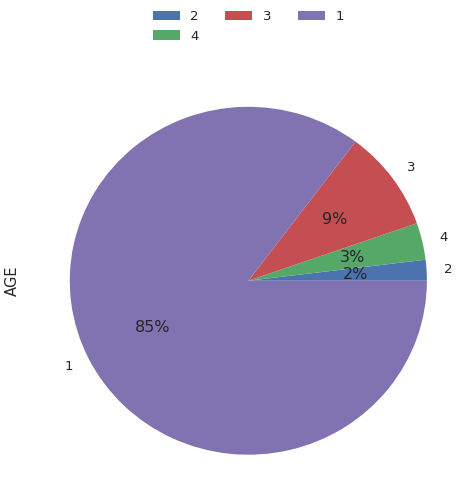

In [12]:
demographicDF = cohorts.getDemographics(1)['pos']
display(demographicDF,gen_tests='true')


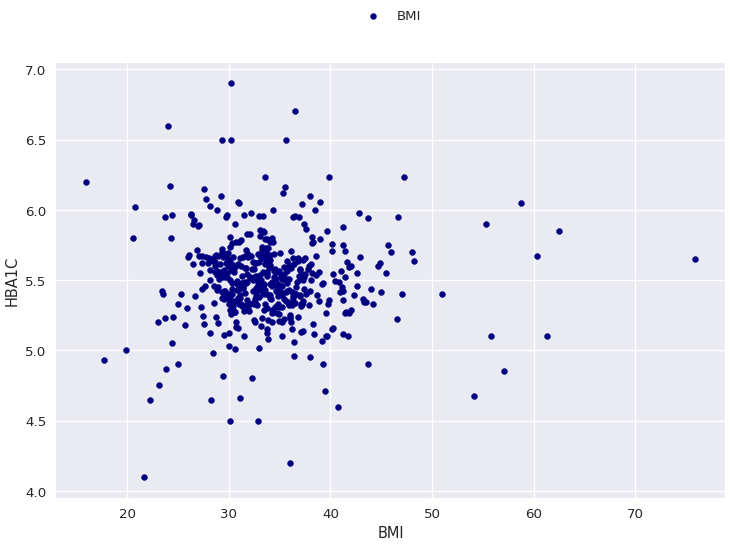

In [14]:
display(demographicDF,gen_tests='true')

In [ ]:
display(demographicDF,cell_id='A275538E87D444648C8FCBBDE2F90FAF',nostore_pixiedust='true',rowCount='500',handlerId='scatterPlot',valueFields='HBA1C',keyFields='BMI',aggregation='SUM',nostore_cw='1097',org_params='gen_tests,nostore_pixiedust',nostore_bokeh='false',prefix='91615a4a')


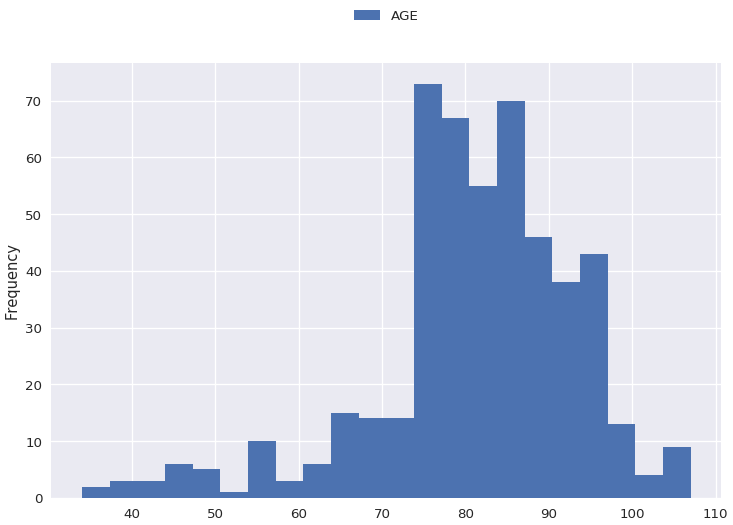

In [15]:
display(demographicDF,gen_tests='true')

In [ ]:
display(demographicDF,cell_id='611A8C946D0E476ABFD2BED2AC2C9F47',nostore_pixiedust='true',rowCount='500',handlerId='histogram',valueFields='AGE',keyFields='STD_GENDER',aggregation='SUM',nostore_cw='1097',org_params='gen_tests,nostore_pixiedust',nostore_bokeh='false',prefix='697e4185')


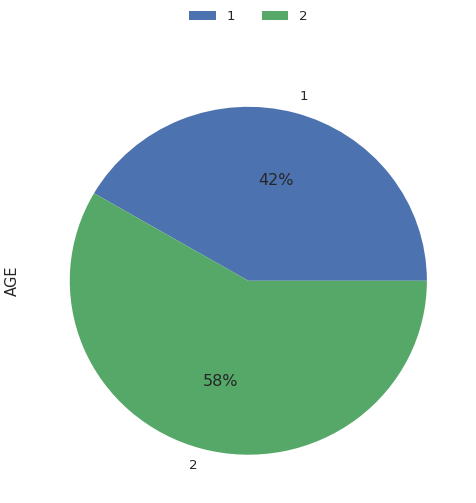

In [16]:
display(demographicDF,gen_tests='true')

In [ ]:
display(demographicDF,cell_id='834A26A2628B4640BE4AF0A9E4F52577',nostore_pixiedust='true',rowCount='500',handlerId='pieChart',valueFields='AGE',keyFields='STD_GENDER',aggregation='SUM',nostore_cw='1097',org_params='gen_tests,nostore_pixiedust',nostore_bokeh='false',prefix='a00a17d8')

# Make sure pixie app is installed

In [10]:
# Uncomment to install pixiedust_health from a local repository
# ATTN: replace with your path to the pixiedust_health repository
!pip install -e /Users/katiecarlson/pixiedust_health

Obtaining file:///Users/katiecarlson/pixiedust_health
  Found existing installation: pixiedust-health 0.1
    Uninstalling pixiedust-health-0.1:
      Successfully uninstalled pixiedust-health-0.1
  Running setup.py develop for pixiedust-health



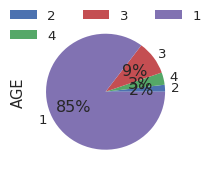


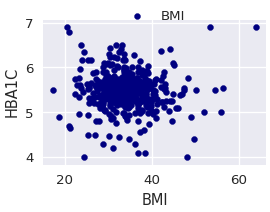


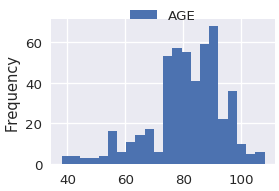


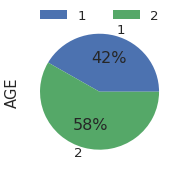

In [9]:
from pixiedust_health import *
PixieHealthApp().run(cohorts, runInDialog='true')

### Page 2: Classsification Model

In [10]:
#display(cohorts.getFeatureVectors(1))

In [11]:
#display(cohorts.getFeatureVectors(2, ['AGE', 'BMI']))